In [1]:
%matplotlib inline

In [3]:
import warnings
warnings.simplefilter(action="ignore", category=FutureWarning)

In [12]:
import os

In [62]:
from keras.applications import vgg16
from keras import models, layers, optimizers
import numpy as np

In [5]:
vgg = vgg16.VGG16( include_top=False, weights='imagenet', input_shape=(150, 150, 3) )
vgg.summary()

58892288/58889256 [==============================] - 10s 0us/step
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_poo

### Fast approach
* No data augmentation
* Run all images through convnet once to create features, and store features as numpy arrays
* Create a dense network and train it on the saved arrays

In [7]:
RUNNING_ON_FLOYDHUB = False

In [8]:
# Directories
# TODO: change for running with floydhub
if not RUNNING_ON_FLOYDHUB:
    train_dir = './data/dogs-vs-cats-small/train/'
    test_dir = './data/dogs-vs-cats-small/test/'
    validation_dir = './data/dogs-vs-cats-small/validation/'
else:
    pass

In [9]:
from keras.preprocessing.image import ImageDataGenerator

In [10]:
# Create image generators
datagen = ImageDataGenerator(rescale=1./255)

In [11]:
train_batches = datagen.flow_from_directory(train_dir,
                                           target_size=(150, 150),
                                           class_mode='binary',
                                           batch_size=20)
validation_batches = datagen.flow_from_directory(validation_dir,
                                           target_size=(150, 150),
                                           class_mode='binary',
                                           batch_size=20)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [15]:
num_of_training_images = 2000
num_of_validation_images = 1000

In [27]:
import time

In [31]:
# Create training features
images_processed = 0
idx = 0
batch_size = 20
training_features = np.zeros((num_of_training_images, 4*4*512)) # Each feature is the 4 * 4 * 512 output from vgg
training_labels = np.zeros((num_of_training_images,))

for input_batch, label_batch in train_batches:
    start = time.time()
    features = vgg.predict(input_batch)
    features = features.reshape( (batch_size, 4*4*512) )
    training_features[idx*batch_size:(idx+1)*batch_size,:] = features
    training_labels[idx*batch_size:(idx+1)*batch_size] = label_batch
    
    idx += 1
    if idx%10 == 0:
        print('idx = {0}. Took {1:.2f} seconds.'.format(idx, time.time() - start))
    images_processed += batch_size
    if images_processed >= num_of_training_images:
        break

idx = 10. Took 10.76 seconds.
idx = 20. Took 9.92 seconds.
idx = 30. Took 9.19 seconds.
idx = 40. Took 9.26 seconds.
idx = 50. Took 10.01 seconds.
idx = 60. Took 9.34 seconds.
idx = 70. Took 9.75 seconds.
idx = 80. Took 9.82 seconds.
idx = 90. Took 9.60 seconds.
idx = 100. Took 9.75 seconds.


In [42]:
# Create validation features
images_processed = 0
idx = 0
batch_size = 20
validation_features = np.zeros((num_of_validation_images, 4*4*512)) # Each feature is the 4 * 4 * 512 output from vgg
validation_labels = np.zeros((num_of_validation_images,))

for input_batch, label_batch in validation_batches:
    start = time.time()
    features = vgg.predict(input_batch)
    features = features.reshape( (batch_size, 4*4*512) )
    validation_features[idx*batch_size:(idx+1)*batch_size,:] = features
    validation_labels[idx*batch_size:(idx+1)*batch_size] = label_batch
    
    idx += 1
    if idx%10 == 0:
        print('idx = {0}. Took {1:.2f} seconds.'.format(idx, time.time() - start))
    images_processed += batch_size
    if images_processed >= num_of_validation_images:
        break

idx = 10. Took 7.54 seconds.
idx = 20. Took 7.12 seconds.
idx = 30. Took 7.45 seconds.
idx = 40. Took 7.45 seconds.
idx = 50. Took 7.08 seconds.


In [51]:
import pickle

In [55]:
# Save the features and labels to save time
with open('vgg_generated_features.pckl', 'wb') as f:
    pickle.dump( [training_features, training_labels, validation_features, validation_labels] , f)

#### Dense Neural Net

In [61]:
model = models.Sequential()
model.add( layers.Dense( 256, activation='relu', input_shape=(4*4*512,) ) )
model.add( layers.Dropout(0.5) )
model.add( layers.Dense( 1, activation='sigmoid' ) )
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 257       
Total params: 2,097,665
Trainable params: 2,097,665
Non-trainable params: 0
_________________________________________________________________


In [63]:
model.compile( optimizer=optimizers.RMSprop(lr=2e-5), loss='binary_crossentropy', metrics=['acc'] )

In [65]:
%%time

history = model.fit(training_features, training_labels, batch_size=20, epochs=30, validation_data=(validation_features, validation_labels) )

CPU times: user 3 µs, sys: 2 µs, total: 5 µs
Wall time: 10 µs
Train on 2000 samples, validate on 1000 samples
Epoch 1/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.5894 - acc: 0.6830 - val_loss: 0.4623 - val_acc: 0.8220
Epoch 2/30
2000/2000 [==============================] - 5s 2ms/step - loss: 0.4293 - acc: 0.8115 - val_loss: 0.3993 - val_acc: 0.8140
Epoch 3/30
2000/2000 [==============================] - 5s 3ms/step - loss: 0.3441 - acc: 0.8505 - val_loss: 0.3371 - val_acc: 0.8650
Epoch 4/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.3069 - acc: 0.8755 - val_loss: 0.3063 - val_acc: 0.8870
Epoch 5/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2680 - acc: 0.8955 - val_loss: 0.2990 - val_acc: 0.8670
Epoch 6/30
2000/2000 [==============================] - 4s 2ms/step - loss: 0.2604 - acc: 0.8990 - val_loss: 0.2857 - val_acc: 0.8750
Epoch 7/30
2000/2000 [==============================] - 7s 4ms/step - loss: 0.2299 - a

In [66]:
#### Plots

In [67]:
import matplotlib.pyplot as plt

In [68]:
val_loss = history.history['val_loss']
val_acc = history.history['val_acc']

train_loss = history.history['loss']
train_acc = history.history['acc']

epoch = history.epoch

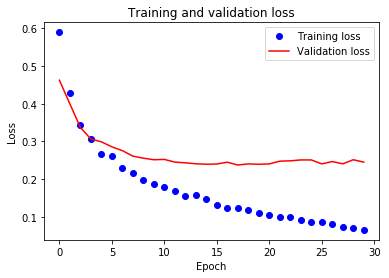

In [69]:
# Loss plots
plt.figure()

plt.plot(epoch, train_loss, 'bo', label='Training loss')
plt.plot(epoch, val_loss, 'r-', label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

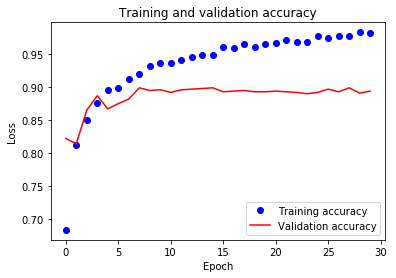

In [70]:
# Accuracy plots
plt.figure()

plt.plot( epoch, train_acc, 'bo', label='Training accuracy' )
plt.plot( epoch, val_acc, 'r-', label='Validation accuracy' )
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()